# Causal Inference in Decision Intelligence – Part 11: Controlling for unknown confounders 

Link to the article:  [Controlling for unknown confounders](https://www.linkedin.com/pulse/causal-inference-decision-intelligence-part-11-unknown-zinoviev-0kbbc)

## Import libraries

In [ ]:
# Check if dowhy is installed, and install it if not
try:
    import dowhy
except ImportError:
    import subprocess
    import sys
    print("Installing dowhy...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "dowhy"])
    import dowhy

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import networkx as nx
import statsmodels.formula.api as smf
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from dowhy.utils import plot
import dowhy
from dowhy import CausalModel
import linearmodels as lm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set the sample size
n = 1000

## A/B test with random assignment

In [3]:
# Generate the data
np.random.seed(2)
Promo1 = np.concatenate((np.ones(500), np.zeros(500)))
C1 = 2 + np.random.randn(n)
C2 = 1 + np.random.randn(n)
Sales1 = 100 + 1 * Promo1 + 8 * C1 + 12 * C2 + np.random.randn(n)
# Create a Pandas dataframe
df1 = pd.DataFrame({'Promo': Promo1, 'Sales': Sales1, 'Covariate1': C1, 'Covariate2': C2})

In [4]:
# Regress Sales on Promo
model1 = smf.ols('Sales ~ Promo', df1).fit()
model1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,127.3762,0.634,200.890,0.000,126.132,128.620
Promo,1.2587,0.897,1.404,0.161,-0.501,3.018


Standard error is high enough to understand the effect of the Promo on Sales

In [5]:
# Regress Sales on Promo with covariates
model1 = smf.ols('Sales ~ Promo + Covariate1 + Covariate2', df1).fit()
model1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,100.0398,0.085,1178.999,0.000,99.873,100.206
Promo,0.9401,0.065,14.388,0.000,0.812,1.068
Covariate1,7.9840,0.033,245.465,0.000,7.920,8.048
Covariate2,12.0387,0.034,359.178,0.000,11.973,12.104


Including covariates inclreases the pricision decreasing the standard error. We may conclude that the effect of Promo on sales is close to 1.

## A/B test with imperfect compliance (IV)

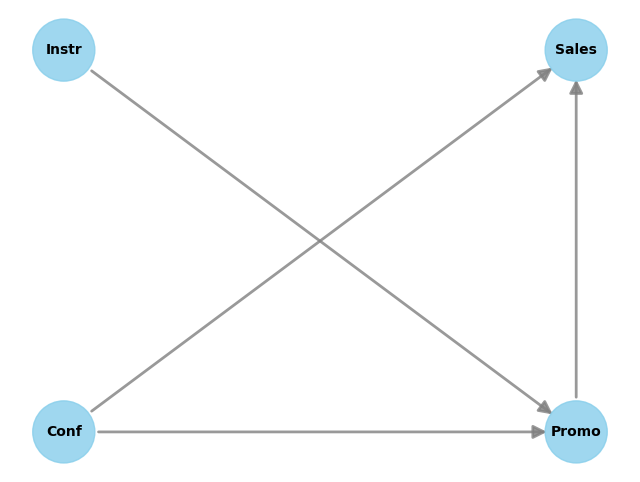

In [6]:
# Create the true DAG
Giv = nx.DiGraph([('Conf', 'Promo'), ('Conf', 'Sales'), ('Instr', 'Promo'), ('Promo', 'Sales')])
plt.rcParams['font.size'] = 10
plot(Giv, figure_size=[8, 6])

In [7]:
# Generate the data
np.random.seed(2)
# Create an instrument
Instr = np.concatenate((np.ones(500), np.zeros(500)))

# Create an unknown confounder
U = np.random.randn(n)

# Create the new promo group affected by confounder
Ut = U[:500]
Contr = np.where(Ut>0, 1, 0)
Promo2 = np.concatenate((Contr, np.zeros(500)))

# Generate Sales
Sales2 = 100 + 10 * Promo2 + 3 * U + np.random.randn(n)

# Create a Pandas dataframe
dfiv = pd.DataFrame({'Promo': Promo2, 'Instrument': Instr, 'Confounder': U, 'Sales': Sales2})

In [8]:
# Regress Sales on Promo without the confounder
modelu = smf.ols('Sales ~ Promo', dfiv).fit()
modelu.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,99.0026,0.101,977.956,0.000,98.804,99.201
Promo,13.4696,0.205,65.589,0.000,13.067,13.873


In [9]:
# Regress Sales on Promo with the confounder
modelc = smf.ols('Sales ~ Promo + U', dfiv).fit()
modelc.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,99.9824,0.037,2680.095,0.000,99.909,100.056
Promo,10.0248,0.083,121.248,0.000,9.863,10.187
U,2.9830,0.035,84.489,0.000,2.914,3.052


In [15]:
# Regress Sales on the instrument 
modeli = smf.ols('Sales ~ Instrument', dfiv).fit()
modeli.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,99.7581,0.264,377.872,0.000,99.240,100.276
Instrument,5.0353,0.373,13.487,0.000,4.303,5.768


In [16]:
# Calculate the compliance rate
Compliance_rate = dfiv.Promo.sum() / dfiv.Instrument.sum()
Compliance_rate

In [17]:
# Calculate average treatment effect
ATE = modeli.params[1] / Compliance_rate
print(f"Average Treatment Effect: {round(ATE, 2)}")

Average Treatment Effect: 10.36


In [18]:
# Specify a two-stage regression model
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
endog = dfiv['Sales']
exog = sm.add_constant(dfiv['Promo'])
instrument = sm.add_constant(dfiv['Instrument'])

# Fit the 2SLS model
model_2sls = IV2SLS(endog, exog, instrument).fit()
print(model_2sls.summary())

                          IV2SLS Regression Results                           
Dep. Variable:                  Sales   R-squared:                       0.768
Model:                         IV2SLS   Adj. R-squared:                  0.768
Method:                     Two Stage   F-statistic:                     664.4
                        Least Squares   Prob (F-statistic):          1.04e-112
Date:                Sat, 14 Jun 2025                                         
Time:                        15:54:52                                         
No. Observations:                1000                                         
Df Residuals:                     998                                         
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         99.7581      0.138    722.217      0.0

## Proxy of a confounder 

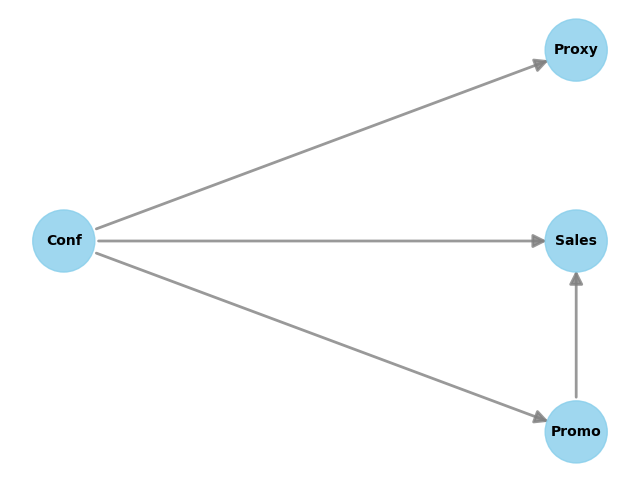

In [19]:
# Create the true DAG
Gpr = nx.DiGraph([('Conf', 'Promo'), ('Conf', 'Sales'), ('Conf', 'Proxy'), ('Promo', 'Sales')])
plt.rcParams['font.size'] = 10
plot(Gpr, figure_size=[8, 6])

In [20]:
# Generate the data
np.random.seed(2)

# Create an unknown confounder
U3 = np.random.randn(n)

# Create a proxy of the confounder
Proxy = 4 * U3 + np.random.randn(n)

# Create the new promo group affected by confounder
Ut = U3[:500]
Contr = np.where(Ut>0, 1, 0)
Promo3 = np.concatenate((Contr, np.zeros(500)))

# Generate Sales
Sales3 = 100 + 10 * Promo3 + 3 * U3 + np.random.randn(n)

# Create a Pandas dataframe
dfpr = pd.DataFrame({'Promo': Promo3, 'Proxy': Proxy, 'Confounder': U3, 'Sales': Sales3})

In [21]:
# Regress Sales on Promo with the confounder
modelc = smf.ols('Sales3 ~ Promo3 + U3', dfpr).fit()
modelc.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,100.0679,0.039,2540.029,0.000,99.991,100.145
Promo3,9.7947,0.087,112.178,0.000,9.623,9.966
U3,3.0258,0.037,81.152,0.000,2.953,3.099


In [22]:
# Regress Sales on Promo with the proxy of the confounder
modelpr = smf.ols('Sales ~ Promo + Proxy', dfpr).fit()
modelpr.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,100.0119,0.047,2128.061,0.000,99.920,100.104
Promo,10.0178,0.104,96.695,0.000,9.814,10.221
Proxy,0.7074,0.011,65.627,0.000,0.686,0.729


## Mediation analysis

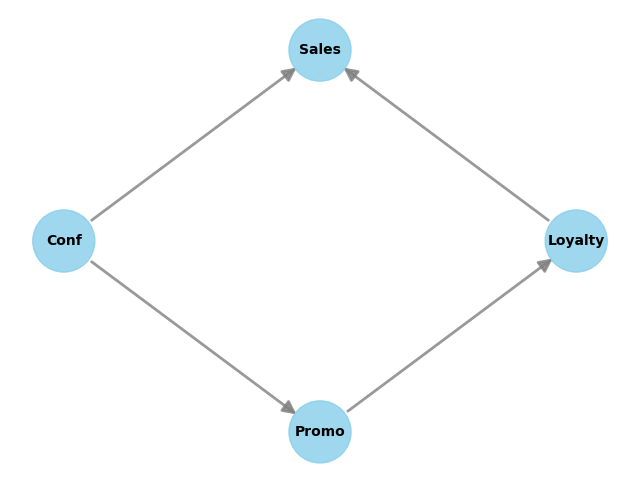

In [23]:
# Create the true DAG
Gmed = nx.DiGraph([('Conf', 'Promo'), ('Conf', 'Sales'), ('Promo', 'Loyalty'), ('Loyalty', 'Sales')])
plt.rcParams['font.size'] = 10
plot(Gmed, figure_size=[8, 6])

In [24]:
# Generate the data
np.random.seed(2)

# Create an unknown confounder
U4 = np.random.randn(n)

# Create the new promo group affected by confounder
Ut = U4[:500]
Contr = np.where(Ut>0, 1, 0)
Promo4 = np.concatenate((Contr, np.zeros(500)))

# Generate a mediator
Loyalty = 5 * Promo4 + np.random.randn(n)

# Generate Sales
Sales4 = 100 + 2 * Loyalty + 3 * U4 + np.random.randn(n)


# Create a Pandas dataframe
dfmed = pd.DataFrame({'Promo': Promo4, 'Loyalty': Loyalty, 'Confounder': U4, 'Sales': Sales4})

In [25]:
# Regress Sales on Promo and confounder
modelm = smf.ols('Sales ~ Promo+Confounder', dfmed).fit()
modelm.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,100.0328,0.086,1167.615,0.000,99.865,100.201
Promo,9.8444,0.190,51.846,0.000,9.472,10.217
Confounder,2.9919,0.081,36.899,0.000,2.833,3.151


In [26]:
# Regress Sales on Loyalty and Promo (Direct effects)
modelmd = smf.ols('Sales ~ Loyalty+Promo', dfmed).fit()
modelmd.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,99.0741,0.103,959.369,0.000,98.871,99.277
Loyalty,1.9984,0.092,21.669,0.000,1.817,2.179
Promo,3.2970,0.507,6.504,0.000,2.302,4.292


In [27]:
# Regress Loyalty on Promo 
modelm2 = smf.ols('Loyalty ~ Promo', dfmed).fit()
modelm2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0120,0.035,-0.338,0.735,-0.082,0.058
Promo,5.0053,0.072,69.613,0.000,4.864,5.146


In [28]:
# Calculate ATE using mediation (frontdoor estimand)
ATEm = modelmd.params[1] * modelm2.params[1]
print(f"Average Treatment Effect: {round(ATEm, 2)}")

Average Treatment Effect: 10.0


## Difference in differences with parallel trends

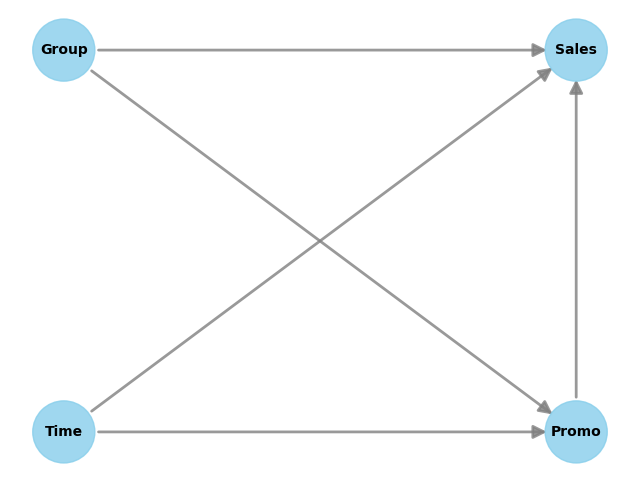

In [29]:
# Create the true DAG
Gdid = nx.DiGraph([('Time', 'Promo'), ('Time', 'Sales'), ('Group', 'Promo'), ('Group', 'Sales'), ('Promo', 'Sales')])
plt.rcParams['font.size'] = 10
plot(Gdid, figure_size=[8, 6])

In [30]:
# Generate the data
# Generate customers' Ids 
Id = pd.Series(range(1,1001))

# Generate dates 
start_date = '2024-05-02'
end_date = '2024-05-04'
Dates = pd.date_range(start=start_date, end=end_date)

# Create the product of Ids and dates
data_did = pd.DataFrame(product(Dates, Id))
data_did = data_did.rename(columns={0: 'Date', 1: "Id"})

# Create promo groups 
data_did['Promo'] = np.where(data_did.Id<501, 1, 0)

# Create the event
data_did['Event'] = np.where(data_did.Date=='2024-05-04', 1, 0)

# Generate Sales with the group difference equal $10, the event effect equal $5, and the promo effect equal $10
data_did['Sales'] = np.where(data_did.Id<501, 20, 10)
data_did['Sales'] = np.where(((data_did.Date=='2024-05-04') & (data_did.Id>500)), 15, data_did.Sales)
data_did['Sales'] = np.where(((data_did.Date=='2024-05-04') & (data_did.Id<501)), 35, data_did.Sales)

np.random.seed(4)
data_did['Sales'] = data_did['Sales'] + np.random.randn(3000)

In [31]:
# Estimate the effect of promo comparing the test and control groups using a naive approach
df1 = data_did[data_did.Date=='2024-05-04']

model_did = smf.ols('Sales ~ Promo', df1).fit()
model_did.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,14.9654,0.044,343.878,0.000,14.880,15.051
Promo,20.0369,0.062,325.560,0.000,19.916,20.158


The coefficient of Promo is biased.

In [32]:
# Apply difference in differences to estimate the effect of the promo
model_did = smf.ols('Sales ~ Promo*Event', data_did).fit().summary()
model_did.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,10.0145,0.031,325.975,0.000,9.954,10.075
Promo,10.0244,0.043,230.728,0.000,9.939,10.110
Event,4.9510,0.053,93.043,0.000,4.847,5.055
Promo:Event,10.0125,0.075,133.053,0.000,9.865,10.160


The effect of Promo is 10.0125 is very close to the true one equal 10. 

In [33]:
# Apply difference in differences to estimate the effect of the promo
model_did1 = smf.ols('Sales ~ Promo*Event', data_did).fit()
# Clustered standard errors 
clustered_results = model_did1.get_robustcov_results(cov_type='cluster', groups=data_did['Id'])
clustered_results.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,10.0145,0.030,330.078,0.000,9.955,10.074
Promo,10.0244,0.044,229.614,0.000,9.939,10.110
Event,4.9510,0.056,88.890,0.000,4.842,5.060
Promo:Event,10.0125,0.076,131.761,0.000,9.863,10.162


In [34]:
# Add Effect variable to the dataset
data_did["Effect"] = data_did.Promo*data_did.Event

In [35]:
# Specofy Two-way fixed effects model (Panel OLS)
mod=lm.PanelOLS.from_formula("Sales ~ Promo + Event + Effect + EntityEffects + TimeEffects", data=data_did.set_index(["Id", "Date"]), drop_absorbed=True)
result=mod.fit(cov_type="clustered", cluster_entity=True)
result

Dep. Variable:,Sales,R-squared:,0.8983
Estimator:,PanelOLS,R-squared (Between):,0.2043
No. Observations:,3000,R-squared (Within):,0.7847
Date:,"Sat, Jun 14 2025",R-squared (Overall):,0.2443
Time:,16:27:00,Log-likelihood,-3564.4
Cov. Estimator:,Clustered,,
,,F-statistic:,1.765e+04
Entities:,1000,P-value,0.0000
Avg Obs:,3.0000,Distribution:,"F(1,1997)"
Min Obs:,3.0000,,
Max Obs:,3.0000,F-statistic (robust):,1.158e+04


### Visualize the results

In [36]:
# extract the coefficients
coef_didco = dict(model_did1.params)
coef_didco = pd.DataFrame([coef_didco]).T
coef_didco = coef_didco.rename(columns={0: "Coeff"})
coef_didco.reset_index(inplace=True)
coef_didco

,index,Coeff
0,Intercept,10.014467
1,Promo,10.024403
2,Event,4.950970
3,Promo:Event,10.012541


In [37]:
# Generte the dates
start_date = '2024-05-02'
end_date = '2024-05-04'
Dates = pd.date_range(start=start_date, end=end_date)
Didco = pd.DataFrame(Dates)
Didco = Didco.rename(columns={0: "Date"})

In [38]:
# Create the dataset
Didco['Control'] = coef_didco.iloc[0,1]
Didco['Event'] = np.where((Didco.Date=='2024-05-04') , Didco['Control'] + coef_didco.iloc[2,1], Didco.Control)

Didco['Parallel'] = Didco['Event'] + coef_didco.iloc[1,1]

Didco['Test'] = np.where((Didco.Date=='2024-05-04') , Didco['Parallel'] + coef_didco.iloc[3,1], Didco.Parallel)

Didco['Date'] = pd.to_datetime(Didco['Date'])
Didco

,Date,Control,Event,Parallel,Test
0,2024-05-02,10.014467,10.014467,20.038870,20.038870
1,2024-05-03,10.014467,10.014467,20.038870,20.038870
2,2024-05-04,10.014467,14.965437,24.989841,35.002382


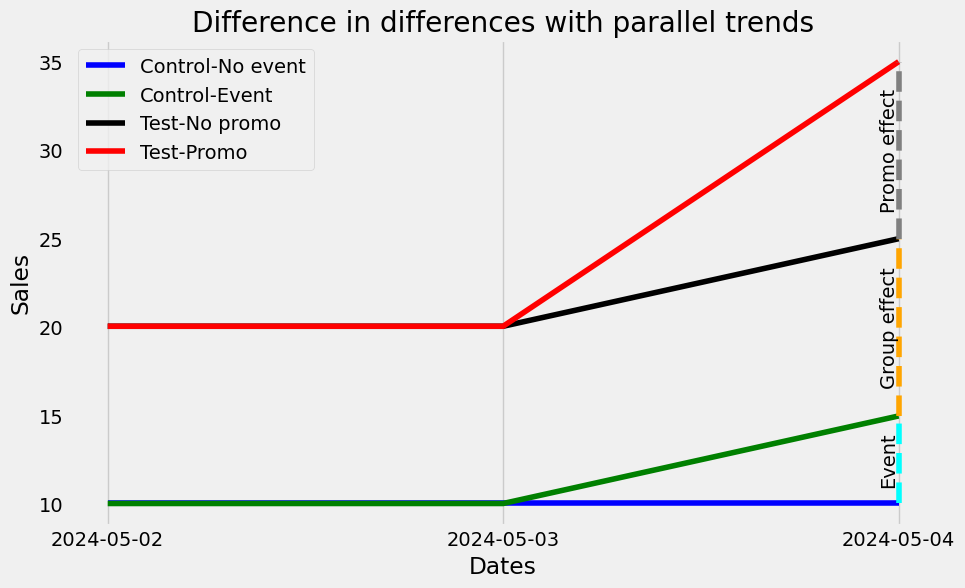

In [39]:
# Create line plots
plt.style.use('fivethirtyeight')
Didco['Date'] = Didco['Date'].astype(str)

plt.figure(figsize=(10, 6))
plt.plot(Didco['Date'], Didco.Control, color='blue', label='Control-No event') 
plt.plot(Didco['Date'], Didco.Event, color='green', label='Control-Event') 
plt.plot(Didco['Date'], Didco.Parallel, color='black', label='Test-No promo') 
plt.plot(Didco['Date'], Didco.Test, color='red', label='Test-Promo') 

plt.plot([Didco['Date'][2], Didco['Date'][2]], [Didco['Parallel'][2], Didco['Test'][2]], linestyle='--', color='gray')
plt.text(Didco['Date'][2], 30, 'Promo effect', rotation=90, verticalalignment='center', horizontalalignment='right')
plt.plot([Didco['Date'][2], Didco['Date'][2]], [Didco['Control'][2], Didco['Event'][2]], linestyle='--', color='cyan') 
plt.text(Didco['Date'][2], 12.5, 'Event', rotation=90, verticalalignment='center', horizontalalignment='right')
plt.plot([Didco['Date'][2], Didco['Date'][2]], [Didco['Event'][2], Didco['Parallel'][2]], linestyle='--', color='orange') 
plt.text(Didco['Date'][2], 20, 'Group effect', rotation=90, verticalalignment='center', horizontalalignment='right')

# Add titles and labels 
plt.title('Difference in differences with parallel trends') 
plt.xlabel('Dates') 
plt.ylabel('Sales') 

plt.grid(axis="y")

# Add a legend 
plt.legend() 
plt.savefig('did2.png')
# Show the plot 
plt.show();

In [40]:
# Using statistics to calculate the promo uplift
d11 = data_did[(data_did.Promo==1) & (data_did.Event==1)].Sales.mean()
d00 = data_did[(data_did.Promo==0) & (data_did.Event==0)].Sales.mean()
d01 = data_did[(data_did.Promo==0) & (data_did.Event==1)].Sales.mean()
d10 = data_did[(data_did.Promo==1) & (data_did.Event==0)].Sales.mean()
Uplift = (d11 - d10) - (d01 - d00)
print(f'Average promo uplift: {round(Uplift, 1)}')

Average promo uplift: 10.0


In [41]:
# Using statistics to calculate the event uplift
Event = (d01 - d00)
print(f'Average event uplift: {round(Event, 1)}')

Average event uplift: 5.0


## Regression Discontinuity Design

In [42]:
# Generate data
Income = pd.Series(range(90,110))

# Generate customers' Ids 
Id = pd.Series(range(1,6))

# Create the product of Ids and dates
data_rd = pd.DataFrame(product(Income, Id))
data_rd = data_rd.rename(columns={0: 'Income', 1: "Id"})

np.random.seed(4)
data_rd['Sales'] = np.where(data_rd.Income<100, np.random.normal(loc=10, scale=2, size=100), np.random.normal(loc=13, scale=2, size=100))
data_rd['Promo'] = np.where(data_rd.Income<100, 0, 1)

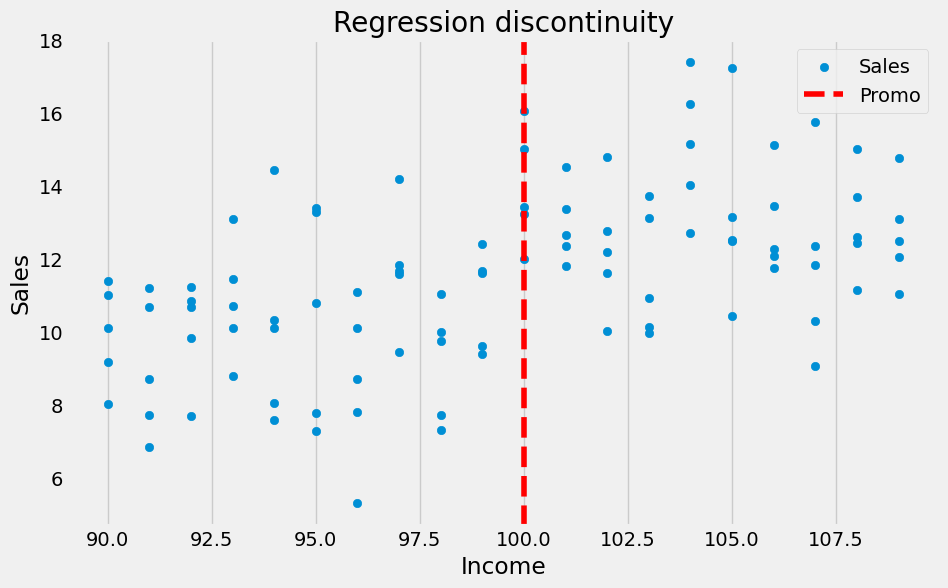

In [43]:
# Visualize the data
plt.figure(figsize=(10, 6))
plt.scatter(data_rd['Income'], data_rd['Sales'], label='Sales')  


plt.axvline(x=data_rd['Income'][50], color='red', linestyle='--', label='Promo')

# Add titles and labels 
plt.title('Regression discontinuity') 
plt.xlabel('Income') 
plt.ylabel('Sales') 

plt.grid(axis="y")

# Add a legend 
plt.legend() 
plt.savefig('rd.png')
# Show the plot 
plt.show();

In [44]:
# Run OLS regression
model_rd = smf.ols('Sales ~ Promo', data_rd).fit()
model_rd.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,10.0849,0.274,36.815,0.000,9.541,10.629
Promo,2.8574,0.387,7.376,0.000,2.089,3.626


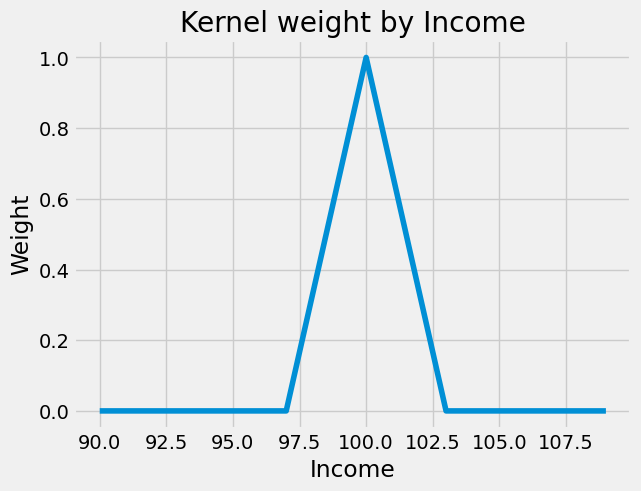

In [45]:
# Create a kernel for WLS
def kernel (R, c, h):
    ind = (np.abs(R-c) <= h).astype(float)
    return ind * (1-np.abs(R-c)/h)

plt.plot(data_rd.Income, kernel(data_rd.Income, c=100, h=3))
plt.xlabel("Income")
plt.ylabel("Weight") 
plt.title("Kernel weight by Income")
plt.savefig('kernel.png')
plt.show;


In [46]:
# Run WLS regression
model_wls = smf.wls('Sales ~ Promo', data_rd,
                   weights=kernel(data_rd.Income, c=100, h=3)).fit()
model_wls.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,10.3414,0.260,39.713,0.000,9.825,10.858
Promo,2.9894,0.319,9.373,0.000,2.356,3.622


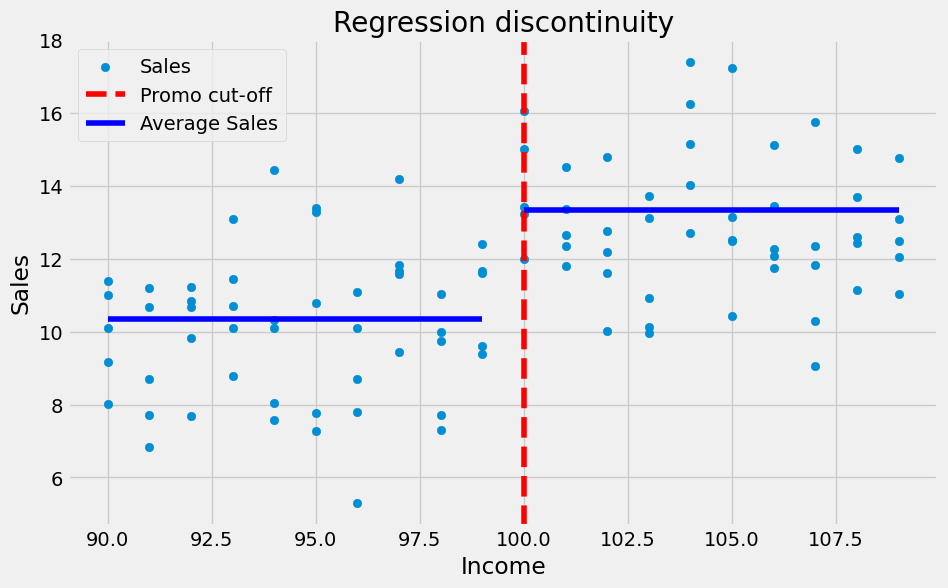

In [47]:
# Visualize the rezults
plt.figure(figsize=(10, 6))
plt.scatter(data_rd['Income'], data_rd['Sales'], label='Sales')  

plt.axvline(x=data_rd['Income'][50], color='red', linestyle='--', label='Promo cut-off')


plt.hlines(y=model_wls.params[0], xmin=90, xmax=99, color='blue', linestyle='-', label='Average Sales')
plt.hlines(y=(model_wls.params[0]+model_wls.params[1]), xmin=100, xmax=109, color='blue', linestyle='-')

# Add titles and labels 
plt.title('Regression discontinuity') 
plt.xlabel('Income') 
plt.ylabel('Sales') 


# Add a legend 
plt.legend() 
plt.savefig('rd2.png')
# Show the plot 
plt.show();

In [48]:
print(f'Average event uplift: {round(model_wls.params[1], 2)}')


Average event uplift: 2.99


In [49]:
# Regression Discontinuity with the PyWhy library
# Create the true DAG
G = nx.DiGraph([('Income', 'Promo'), ('Promo', 'Sales')])
model = CausalModel(data=data_rd,
                     graph=G,
                     treatment="Promo",
                     outcome="Sales")

In [50]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d              
────────(E[Sales])
d[Promo]          
Estimand assumption 1, Unconfoundedness: If U→{Promo} and U→Sales then P(Sales|Promo,,U) = P(Sales|Promo,)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                     -1⎤
 ⎢    d            ⎛    d             ⎞  ⎥
E⎢─────────(Sales)⋅⎜─────────([Promo])⎟  ⎥
 ⎣d[Income]        ⎝d[Income]         ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Sales then ¬(U →→{Income})
Estimand assumption 2, Exclusion: If we remove {Income}→{Promo}, then ¬({Income}→Sales)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [51]:
causal_estimate_regdist = model.estimate_effect(identified_estimand,
        method_name="iv.regression_discontinuity",
        method_params={'rd_variable_name':'Income',
                       'rd_threshold_value':100,
                       'rd_bandwidth': 10})
print(causal_estimate_regdist)
print("Causal Estimate is " + str(causal_estimate_regdist.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                     -1⎤
 ⎢    d            ⎛    d             ⎞  ⎥
E⎢─────────(Sales)⋅⎜─────────([Promo])⎟  ⎥
 ⎣d[Income]        ⎝d[Income]         ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Sales then ¬(U →→{Income})
Estimand assumption 2, Exclusion: If we remove {Income}→{Promo}, then ¬({Income}→Sales)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
 ⎡        d                ⎤
E⎢──────────────────(Sales)⎥
 ⎣dlocal_rd_variable       ⎦
────────────────────────────
 ⎡        d                ⎤
E⎢──────────────────(Promo)⎥
 ⎣dlocal_rd_variable       ⎦
Estimand assumption 1, As-if-random: If U→→Sales then ¬(U →→{Income})
Estimand assumption 2, Exclusion: If we remove {Income}→{Promo}, then ¬({Income}→Sales)
Estimand assumption 3, tre